In [11]:
import os 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier         
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [40]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR,"data")
TRAIN_DIR = os.path.join(DATA_DIR,"TrainningDataset.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TEST_DIR = os.path.join(DATA_DIR,"TestingDataset.csv")


In [41]:
X = pd.read_csv(TRAIN_DIR)                 # contient la colonne 'Id'
y = pd.read_csv(LABEL_DIR)                 # contient 'Id' et 'Label'

y = y.set_index("Id")["Category"]             # Series indexée par Id
X = X.sample(n=X.shape[0])
y = y.reindex(X["Id"])

In [42]:
X_train = X.drop(columns=["Id"])
y_train = y.drop(columns=["Id"])

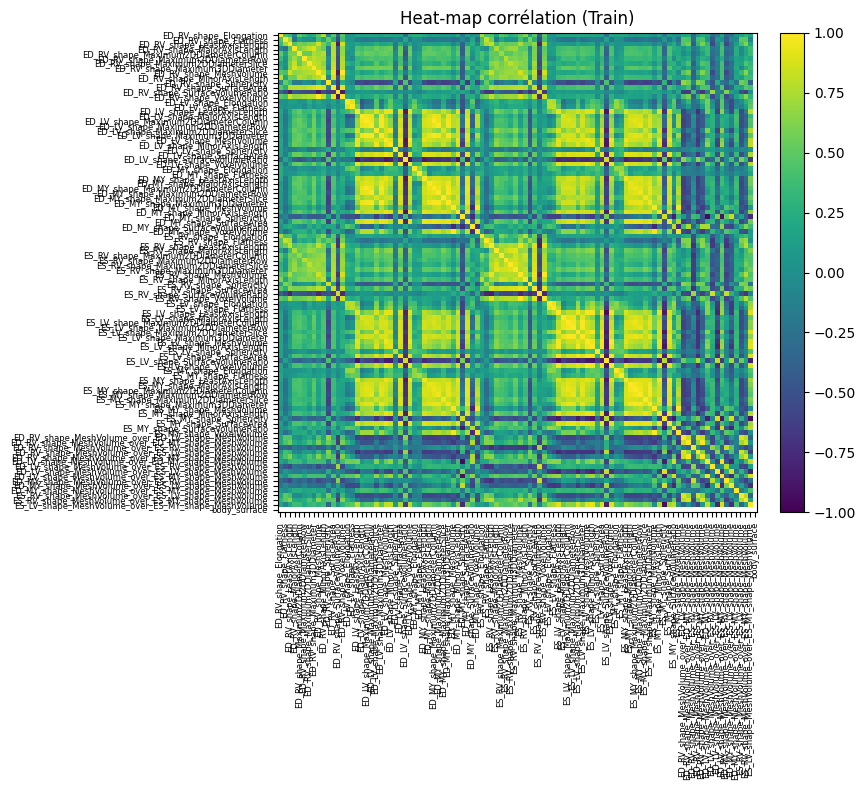

In [43]:
# Affichage de la Heat Map corrélation : on cherche à identifier les variables trop corrélés afin de les enlevés.

corr = X_train.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(9, 8))
cax = ax.imshow(corr, vmin=-1, vmax=1, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=6)
ax.set_yticklabels(corr.columns, fontsize=6)
fig.colorbar(cax, fraction=0.046, pad=0.04)
plt.title("Heat-map corrélation (Train)")
plt.tight_layout()
plt.show()

In [44]:
# On retire les features avec une Variance trop faible. Elle ne permettront pas de séparer la donée.

var_sel = VarianceThreshold(threshold=0.0)     
X1 = var_sel.fit_transform(X_train)
selected_var = X_train.columns[var_sel.get_support()]


In [45]:

# 4 · Sélection 2 : corrélation élevée (> 0.9) --------------------------------
def drop_high_corr(df, thr=0.9):
    c = df.corr(numeric_only=True).abs()
    upper = c.where(np.triu(np.ones(c.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thr)]
    return df.drop(columns=to_drop), to_drop

X2_df, highly_corr = drop_high_corr(
    pd.DataFrame(X1, columns=selected_var), thr=0.90
)
print(f"Variables retirées pour corrélation > 0.9 : {len(highly_corr)}")


Variables retirées pour corrélation > 0.9 : 49


In [ ]:

# 5 · Sélection 3 : méthode embarquée (Random Forest + RFE) --------------------
rf   = RandomForestClassifier(n_estimators=500 ,n_jobs=-1)
step = max(1, int(0.1 * X2_df.shape[1]))      # retirer 10 % des variables / étape
rfe  = RFE(estimator=rf, n_features_to_select=30, step=step)  # garde 30 features

rfe.fit(X2_df, y_train)
selected_final = X2_df.columns[rfe.get_support()]
print(f"Variables finales retenues ({len(selected_final)}) :")
print(selected_final.tolist())


Variables finales retenues (35) :
['ED_RV_shape_Maximum2DDiameterColumn', 'ED_RV_shape_MeshVolume', 'ED_RV_shape_SurfaceVolumeRatio', 'ED_LV_shape_LeastAxisLength', 'ED_LV_shape_Maximum2DDiameterSlice', 'ED_LV_shape_Sphericity', 'ED_LV_shape_SurfaceVolumeRatio', 'ED_MY_shape_Flatness', 'ED_MY_shape_Maximum2DDiameterSlice', 'ED_MY_shape_MeshVolume', 'ED_MY_shape_Sphericity', 'ED_MY_shape_SurfaceVolumeRatio', 'ES_RV_shape_Flatness', 'ES_RV_shape_LeastAxisLength', 'ES_RV_shape_MajorAxisLength', 'ES_RV_shape_Maximum2DDiameterColumn', 'ES_RV_shape_Maximum2DDiameterRow', 'ES_RV_shape_Maximum2DDiameterSlice', 'ES_RV_shape_MinorAxisLength', 'ES_RV_shape_SurfaceVolumeRatio', 'ES_LV_shape_Elongation', 'ES_LV_shape_MajorAxisLength', 'ES_LV_shape_Sphericity', 'ES_MY_shape_Flatness', 'ES_MY_shape_Sphericity', 'ES_MY_shape_SurfaceVolumeRatio', 'ED_RV_shape_MeshVolume_over_ED_LV_shape_MeshVolume', 'ED_RV_shape_MeshVolume_over_ED_MY_shape_MeshVolume', 'ED_RV_shape_MeshVolume_over_ES_RV_shape_MeshVolum

In [54]:

# 6 · Sauvegarde de la liste et du jeu réduit ---------------------------------
pd.Series(selected_final).to_csv(
    os.path.join(DATA_DIR, "SelectedFeatures.csv"), index=False, header=["Feature"]
)

X_train_reduced = X[["Id"] + selected_final.tolist()]

X_train_reduced.to_csv(
    os.path.join(DATA_DIR, "TrainningDataset_reduced.csv"), index=False
)


In [55]:


pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", rf)
])
cv = StratifiedKFold(n_splits=5, shuffle=True)
scores = cross_val_score(pipe,
                         X_train_reduced.drop(columns=["Id"]),
                         y_train.squeeze(),
                         cv=cv, scoring="accuracy")
print("ROC-AUC CV (5-fold) :", scores.mean(), "±", scores.std())

ROC-AUC CV (5-fold) : 0.95 ± 0.04472135954999579
